# Diffusion 在1D/2D的例子

## 加载数据集

In [121]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
ibc_parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(ibc_parent_dir)

import dataset_2d
from diffusion_policy.model.common.lr_scheduler import get_scheduler
import tqdm
import matplotlib.pyplot as plt


超参调整

In [ ]:
experiment_name = "256x4" # custom experiment name
custom_seed = 42 # custom seed

train_dataset_size = 256 # custom dataset size
train_batch_size = 64
trian_num_workers = 1

test_dataset_size = 512
test_batch_size = 64
test_num_workers = 1

net_seq = [256, 256, 256, 256]  # custom network structure
num_epochs = 3000
learning_rate = 1e-4
weight_decay = 1e-5

num_inference_steps = 1000
num_train_timesteps = 100

In [123]:
train_dataset_config = dataset_2d.ToyDatasetConfig(
    dataset_size=train_dataset_size,
    seed=custom_seed,
    mode = 'circle_line',    
)
train_dataset = dataset_2d.Toy1DDataset(train_dataset_config)  # data: coordinate regression shape:（N,2)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=trian_num_workers,
    pin_memory=torch.cuda.is_available(),
)

# Test split.
test_dataset_config = dataset_2d.ToyDatasetConfig(
    dataset_size=test_dataset_size,
    seed=custom_seed, 
    mode = 'circle_line',
)
test_dataset = dataset_2d.Toy1DDataset(test_dataset_config)
test_dataset.exclude(train_dataset.coordinates) # 防止测试集中包含训练集的数据
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=test_num_workers,
    pin_memory=torch.cuda.is_available(),
)

Resampled 256 data points.


batch的类型: <class 'list'>
batch包含的元素数量: 2
batch[0].shape:torch.Size([64, 1])
batch[1].shape:torch.Size([64, 3])
x = torch.Size([1])
y = torch.Size([3])


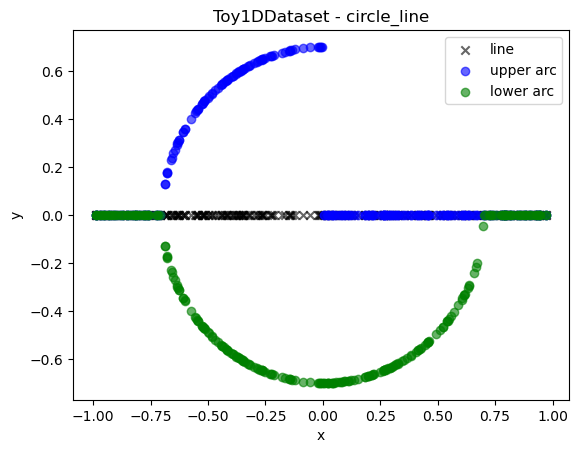

In [124]:
batch = next(iter(train_dataloader))

print("batch的类型:", type(batch))  # data + label
print("batch包含的元素数量:", len(batch))

for i in range(len(batch)):
    print("batch[{}].shape:{}".format(i, batch[i].shape))

# Visualize one instance.
x, y = train_dataset[np.random.randint(len(train_dataset))]
print("x =", x.shape)
print("y =", y.shape)

xs = train_dataset.coordinates.flatten()
ys = train_dataset.targets  # shape (N, 3) for circle_with_line

plt.figure()

if ys.ndim == 1 or ys.shape[1] == 1:
    # 普通 1D 情况
    plt.scatter(xs, ys.flatten(), marker="x", c="blue", alpha=0.6)

else:
    # 分别绘制 line / upper_arc / lower_arc
    plt.scatter(xs, ys[:, 0], marker="x", c="black", alpha=0.6, label="line")
    plt.scatter(xs, ys[:, 1], marker="o", c="blue", alpha=0.6, label="upper arc")
    plt.scatter(xs, ys[:, 2], marker="o", c="green", alpha=0.6, label="lower arc")

plt.title(f"Toy1DDataset - {train_dataset.mode}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


batch的类型: <class 'list'>
batch包含的元素数量: 2
batch[0].shape:torch.Size([64, 1])
batch[1].shape:torch.Size([64, 3])
x = torch.Size([1])
y = torch.Size([3])
x = tensor([0.8968])
y = tensor([0., 0., 0.])


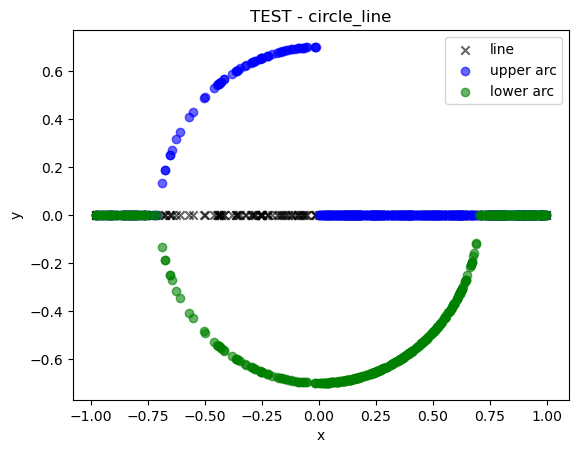

In [125]:
batch = next(iter(test_dataloader)) 

print("batch的类型:", type(batch))  # data + label
print("batch包含的元素数量:", len(batch))

for i in range(len(batch)):
    print("batch[{}].shape:{}".format(i, batch[i].shape))

x, y = test_dataset[np.random.randint(len(train_dataset))]
print("x =", x.shape)
print("y =", y.shape)
print("x =", x)
print("y =", y)

xs = test_dataset.coordinates.flatten()
ys = test_dataset.targets  # shape (N, 3) for circle_with_line

plt.figure()

if ys.ndim == 1 or ys.shape[1] == 1:
    # 普通 1D 情况
    plt.scatter(xs, ys.flatten(), marker="x", c="blue", alpha=0.6)

else:
    # 分别绘制 line / upper_arc / lower_arc
    plt.scatter(xs, ys[:, 0], marker="x", c="black", alpha=0.6, label="line")
    plt.scatter(xs, ys[:, 1], marker="o", c="blue", alpha=0.6, label="upper arc")
    plt.scatter(xs, ys[:, 2], marker="o", c="green", alpha=0.6, label="lower arc")

plt.title(f"TEST - {test_dataset.mode}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


## 搭建网络

需要前向扩散，逆向扩散过程

噪声调度

设计网络，使用MLP网络即可满足要求，但额外还需要：

- condition sample
- predict
- compute loss

In [126]:
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict

# DDPM
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
# from diffusion_policy.model.common.normalizer import LinearNormalizer

In [127]:
input_dim = 36  # 1维坐标 + 3维动作 + 32维时间戳embedding
output_dim = 3  # 输出3维动作
class MLP(nn.Module):
    def __init__(self, 
                 input_dim: int,
                 hidden_dims: list[int],
                 output_dim: int, 
                 activation: nn.Module = nn.ReLU(), 
                 use_batch_norm: bool = False,
                 dropout_rate: float = 0.0):
        super().__init__()
        
        layers = []
        in_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(activation)
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_dim
        
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)
        
    # 把所有东西处理好再传入网络  
    def forward(self, trajectory: torch.Tensor, timestamp: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        emb_dim = 32
        timestamp_float = timestamp.squeeze(1).float()  # [B,1] → [B]，且为 float
        # print("in compute loss the timestamp_float:", timestamp_float)

        timestamp_emb = torch.zeros((timestamp_float.shape[0], emb_dim), 
                                dtype=torch.float32, 
                                device=timestamp.device)
        

        div_term = torch.exp(
            torch.arange(0, emb_dim, 2, dtype=torch.float32) *  # 0,2,4,...,30（共16个元素）
            -(np.log(1e4) / emb_dim)  # 缩放因子，控制频率衰减
        ).to(timestamp.device)
        # print("in compute loss the div_term:", div_term)

        # timestamp_float [B] × div_term [16] -> 广播为 [B,16]，对应 emb 的 0::2 列
        timestamp_emb[:, 0::2] = torch.sin(timestamp_float.unsqueeze(1) * div_term)
        timestamp_emb[:, 1::2] = torch.cos(timestamp_float.unsqueeze(1) * div_term)
        # print("in compute loss the timestamp_emb:", timestamp_emb)

        fused = torch.cat([trajectory, timestamp_emb, x], dim=1)  # Now input_dim = 3 + 32 + 1 = 36; update accordingly
        return self.net(fused)

In [128]:
DiffusionMLP = MLP(
    input_dim=input_dim,
    hidden_dims=net_seq,
    output_dim=output_dim,
    activation=nn.ReLU(),
    use_batch_norm=False,   # 使用批归一化
    dropout_rate=1e-3       # 每层Dropout比率1e-3
)

关于DiffusionMLP的定义与使用：

去噪网络建模为$\epsilon_{\theta}(O,A,k)$

- 输入使用：dim(O) + dim(A) + dim(k)
- 输出使用：y.shape = (batch_size, 3)
- 不需要normalization, mask, condition

所以，只需要x, y, t, input_dim, outputdim即可 

In [129]:
class DiffusionMlpPolicy():
    def __init__(self, 
        model: MLP,
        noise_scheduler: DDPMScheduler(num_train_timesteps=100),
        input_dim, 
        output_dim, 
        num_inference_steps=None,
        num_train_timesteps=None,
        oa_step_convention=False,
        # parameters passed to step
        **kwargs):
        self.model = model
        self.noise_scheduler = noise_scheduler
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.oa_step_convention = oa_step_convention
        self.kwargs = kwargs
        self.num_inference_steps = num_inference_steps
        self.num_train_timesteps = num_train_timesteps
        print("Scheduler train timesteps:", self.noise_scheduler.num_train_timesteps)

    
    # ========= inference  ============   
    def conditional_sample(self, condition_data, global_cond, generator=None, **kwargs):
        model = self.model
        scheduler = self.noise_scheduler

        # 随机初始化一个高斯噪声轨迹
        trajectory = torch.randn(
            size=condition_data.shape, 
            dtype=condition_data.dtype,
            device=condition_data.device,
            generator=generator)
        
        # print("in sample the init trajectory:", trajectory)

        # 设置采样步数
        scheduler.set_timesteps(self.num_inference_steps)
        # print("scheduler timesteps:", scheduler.timesteps)
        B = trajectory.shape[0]

        for diffusion_t in scheduler.timesteps:
            # print("in conditional sample the current diffusion_t:", diffusion_t)
            # print("完整时间步列表（前5个和后5个）：")
            # print(scheduler.timesteps[:5])  # 输出：[990, 980, 970, 960, 950]
            # print(scheduler.timesteps[-5:]) # 输出：[40, 30, 20, 10, 0]
            t_expanded = diffusion_t.repeat(B).unsqueeze(1).to(trajectory.device)
            # print("expanded timestamp shape:", t_expanded.shape)  # torch.Size([8, 1])
            # 噪声预测（使用扩展后的时间步）
            model_output = model(trajectory, t_expanded, global_cond)

            # 去噪过程
            trajectory = scheduler.step(
                model_output, diffusion_t, trajectory,  # 注意这里仍用原始diffusion_t（scheduler需要标量时间步）
                generator=generator,** kwargs
            ).prev_sample      

        return trajectory
    
    def predict_action(self, batch):
        global_cond, condition_data = batch
        # run sampling
        nsample = self.conditional_sample(
            condition_data, global_cond,
            **self.kwargs)
        
        # unnormalize prediction
        # action_pred = nsample[...,:Da]
        action_pred = nsample
        result = {
            'action_pred': action_pred
        }
        return result
    
    def compute_loss(self, batch):
        x, y = batch
        global_cond = x
        trajectory = y
        # print("x shape:", x.shape)
        # print("target shape:", target.shape)

        # Sample noise that we'll add to the images
        bsz = trajectory.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, self.num_train_timesteps, 
            (bsz,), device=trajectory.device
        ).long()
        
        noise = torch.randn_like(trajectory, device=trajectory.device)
        # 使用 scheduler.add_noise（它会根据 timesteps 对噪声做缩放）
        noisy_trajectory = self.noise_scheduler.add_noise(trajectory, noise, timesteps)

        t_expanded = timesteps.unsqueeze(1)
        
        # Predict the noise residual
        pred = self.model(noisy_trajectory, t_expanded, global_cond)

        # print("timesteps:", timesteps)
        # print("ground truth target:", trajectory)
        # print("noisy trajectory: ", noisy_trajectory)
        # print("added noise: ", noise)


        loss = F.mse_loss(pred, noise, reduction='none')
        loss = loss.mean()
        return loss

粗略的写完了diffusion的sample和compute loss，下一步开始train和debug

In [130]:
dpp = DiffusionMlpPolicy(model = DiffusionMLP,
                         noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps),
                            input_dim = input_dim,
                            output_dim = output_dim,
                            num_inference_steps = num_inference_steps,
                            num_train_timesteps = num_train_timesteps)
optimizer = torch.optim.AdamW(dpp.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs, eta_min=1e-5
)

Scheduler train timesteps: 100


Epoch 3000/3000 | Avg Loss: 0.0375: 100%|██████████| 3000/3000 [02:54<00:00, 17.18it/s]



训练结束！开始绘制loss曲线...


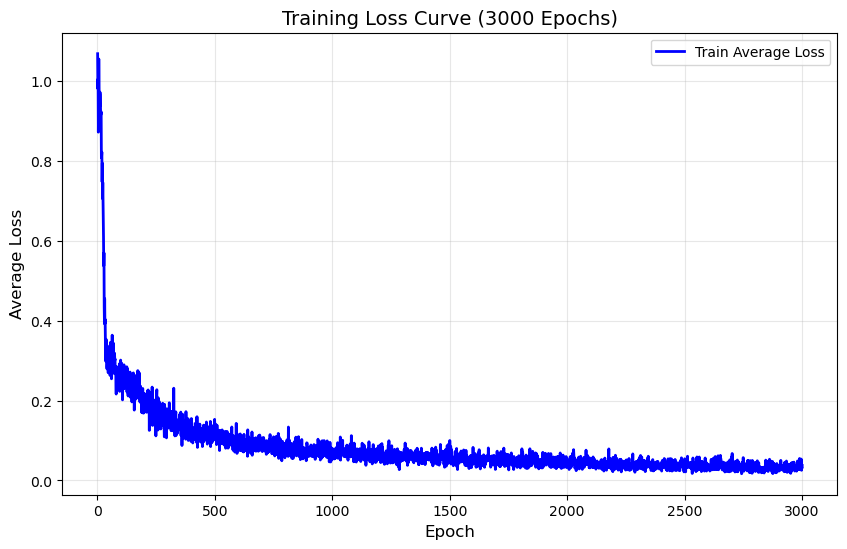


训练总结：
总epoch数：3000
初始loss：1.0687
最终loss：0.0375
loss下降幅度：96.49%
最后epoch日志：{'epoch': 3000, 'train_avg_loss': 0.03750054957345128, 'lr': 0.0001}


In [ ]:
train_avg_loss_history = []  # 存储「每个epoch的平均loss」，用于训练后绘图

dpp.model.train()
pbar = tqdm.tqdm(range(num_epochs), desc="Total Training Progress")
for local_epoch_idx in pbar:
    step_log = dict()
    train_batch_losses = list()  # 记录当前epoch内「所有批次的loss」
    
    for batch in train_dataloader:
        loss = dpp.compute_loss(batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # lr_scheduler.step()
        train_batch_losses.append(loss.item())
    

    avg_epoch_loss = sum(train_batch_losses) / len(train_batch_losses)
    train_avg_loss_history.append(avg_epoch_loss)
    
    pbar.set_description(f"Epoch {local_epoch_idx+1}/{num_epochs} | Avg Loss: {avg_epoch_loss:.4f}")
    
    step_log = {
        'epoch': local_epoch_idx + 1,
        'train_avg_loss': avg_epoch_loss,
        'lr': lr_scheduler.get_last_lr()[0]
    }


# -------------------------- 训练结束后：统一绘制loss曲线 --------------------------
print("\n训练结束！开始绘制loss曲线...")

epochs = list(range(1, len(train_avg_loss_history) + 1))  # 如 [1,2,...,1000]

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_avg_loss_history, color='blue', linewidth=2, label='Train Average Loss')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title(f'Training Loss Curve ({num_epochs} Epochs)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)  # 添加网格，便于观察趋势
# 可选：保存图片（高清格式）
plt.savefig(f'loss_curve_{num_epochs}_{experiment_name}_data{train_dataset_size}.png', dpi=300, bbox_inches='tight')
# 显示图表
plt.show()


# -------------------------- 打印训练总结 --------------------------
print("\n训练总结：")
print(f"总epoch数：{num_epochs}")
print(f"初始loss：{train_avg_loss_history[0]:.4f}")  # 第一个epoch的平均loss
print(f"最终loss：{train_avg_loss_history[-1]:.4f}")  # 最后一个epoch的平均loss
print(f"loss下降幅度：{((train_avg_loss_history[0] - train_avg_loss_history[-1]) / train_avg_loss_history[0] * 100):.2f}%")
print(f"最后epoch日志：{step_log}")

训练完了，试一下evaluation

In [132]:
dpp.model.eval()
with torch.no_grad():
    test_losses = []
    all_inputs = []  # 存储输入x（形状：[N,1]）
    all_preds = []   # 存储预测值（提取张量并转NumPy）
    all_targets = [] # 存储目标值y（形状：[N,3]）
    
    for batch in test_dataloader:
        x, y = batch  # 解包输入x和目标y
        # 计算损失
        loss = dpp.compute_loss(batch)
        test_losses.append(loss.item())
        
        # 预测并提取action_pred（张量→NumPy）
        prediction = dpp.predict_action(batch)
        pred_tensor = prediction['action_pred']  # 取出张量
        pred_np = pred_tensor.cpu().numpy()      # 转NumPy（CPU上）
        all_preds.append(pred_np)
        
        # 收集输入x和目标y
        all_inputs.append(x.cpu().numpy())       # 输入x
        all_targets.append(y.cpu().numpy())      # 目标y（关键：补充这行）
    
    avg_test_loss = sum(test_losses) / len(test_losses)
    print(f"测试集平均loss: {avg_test_loss:.4f}")

测试集平均loss: 0.0375


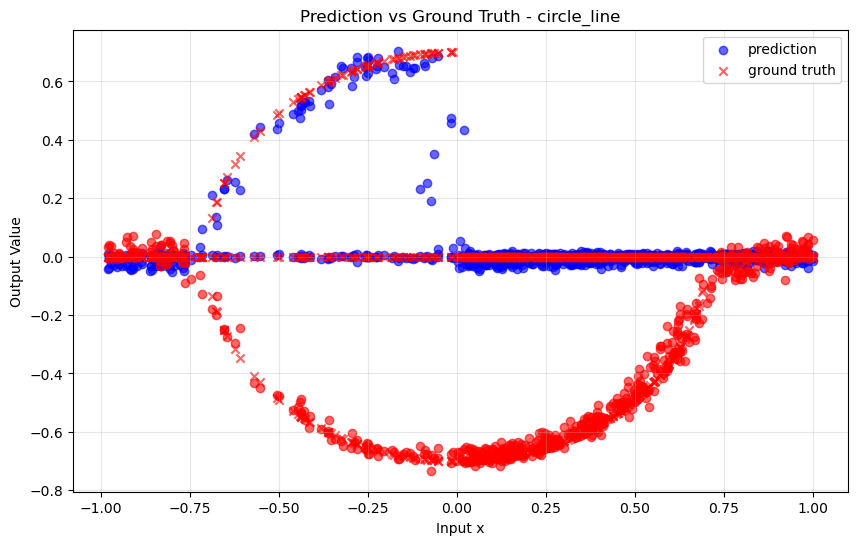

In [ ]:
# 拼接所有数据（确保维度正确）
xs = np.concatenate(all_inputs, axis=0).flatten()  # 输入x（1维，总样本数）
ys_pred = np.concatenate(all_preds, axis=0)        # 预测值（[总样本数, 3]）
ys_target = np.concatenate(all_targets, axis=0)    # 目标值（[总样本数, 3]）

# 绘图
plt.figure(figsize=(10, 6))

# 因为数据是3维输出（3个维度），直接绘制三个维度的预测与真实值
# 预测值（用圆形标记，不同颜色区分维度）
plt.scatter(xs, ys_pred[:, 0], marker="o", c="blue", alpha=0.6, label="prediction")
plt.scatter(xs, ys_pred[:, 1], marker="o", c="blue", alpha=0.6)
plt.scatter(xs, ys_pred[:, 2], marker="o", c="red", alpha=0.6)

# 真实值（用叉形标记，不同颜色区分维度）
plt.scatter(xs, ys_target[:, 0], marker="x", c="red", alpha=0.6, label="ground truth")
plt.scatter(xs, ys_target[:, 1], marker="x", c="red", alpha=0.6)
plt.scatter(xs, ys_target[:, 2], marker="x", c="red", alpha=0.6)


save_dir = "./prediction_plots/" 
os.makedirs(save_dir, exist_ok=True)
file_name = f"{train_dataset_config.mode}_epoch_{num_epochs}_{experiment_name}_data{test_dataset_size}_samples.png"
save_path = os.path.join(save_dir, file_name)


plt.savefig(
    save_path,
    dpi=300, 
    bbox_inches='tight',
    facecolor='white'
)

# 图表配置
plt.title(f"Prediction vs Ground Truth - {train_dataset_config.mode}")
plt.xlabel("Input x")
plt.ylabel("Output Value")
plt.legend()  # 显示图例区分维度和预测/真实
plt.grid(alpha=0.3)  # 网格线便于观察
plt.show()

In [134]:
scheduler = DDPMScheduler(num_train_timesteps=100, beta_start=0.0001, beta_end=0.02, beta_schedule="linear")
scheduler.set_timesteps(100)
print("完整时间步列表（前5个和后5个）：")
print(scheduler.timesteps[:5])  # 输出：[990, 980, 970, 960, 950]
print(scheduler.timesteps[-5:]) # 输出：[40, 30, 20, 10, 0]

完整时间步列表（前5个和后5个）：
tensor([99, 98, 97, 96, 95])
tensor([4, 3, 2, 1, 0])
